In [1]:
import numpy as np
import pandas as pd 
import random

from joblib import Parallel, delayed

import operator
from functools import reduce

import torch
import torch.nn as nn
import torch.optim as optim

from qpth.qp import QPFunction

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import feat_eng as fe
import data_selector_items as dsi
import params_newsvendor as prm

from mip import Model, xsum, minimize, maximize, BINARY, INTEGER, CutType, OptimizationStatus

import datetime
import logging
logging.basicConfig(filename='results.log', level=logging.INFO)

***
$\mathbf{\text{Linear Programming for Inventory Optimization/News Vendor}}$<br>

The problem: Walmart data is composed by some features X and sales of items Y for each day. We build an Optimization Problem (OP) to minimize a specific cost function (we will detail which cost function is it afterward) for all days (here, we aim do minimize the average of the cost function through all the days in the test data). The cost function depends on the sales Y of some specific items (which is unknown but predictable) and decision variables Z are the orders of the same items.

$\mathbf{\text{Combined approach (End-to-end learning) vs Decoupled approach (MSE + Solver)}}$<br>
***

In [2]:
#################################################################################
## Initial parameters ###########################################################
#################################################################################

# Seed number to replicate results
seed_number = 0

# First day to be considered in the data
start_day = 900

# Quadratic factor to allow twice differentiation
# It is a percentual of the linear parameter
q_factor = 0.08

# is_discrete = True -> Formulates a MILP and apply relaxation and gomory cuts
# is_discrete = False -> Feasible region is continuous
is_discrete = False

# If discrete, how many maximum cuts to apply in the Gomory?
N_try_cuts = 20




# Max iterations while training
N_it = 400

# Number of items to consider in the newsvendor
n_items = 15

# Number of batches in the SGD (minibatch)
# How many Y_I will be considered in the gradient? 
n_batches = 5

# Result output
train_graph = False

# Split data percentage [train, val, test]
split_perc = [0.5, 0.25, 0.25]

# Path of data files
path_data = './data/'

In [3]:
# Use the initial parameters to set some other global parameters
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

m_type = 'cont'
if is_discrete:
    m_type = 'disc'

***
$\mathbf{\text{Optimization problem deterministic parameters}}$<br>
***
\begin{align}
&q^{(k)}: \text{Quadratic term } &&\text{Fixed cost } &\text{Item k}\\
&q_s^{(k)}: \text{Quadratic term } &&\text{Shortage cost } &\text{Item k}\\
&q_w^{(k)}: \text{Quadratic term } &&\text{Excess cost } &\text{Item k}\\\\
&c^{(k)}: \text{Linear term } &&\text{Fixed cost } &\text{Item k}\\
&c_s^{(k)}: \text{Linear term } &&\text{Shortage cost } &\text{Item k}\\
&c_w^{(k)}: \text{Linear term } &&\text{Excess cost } &\text{Item k}\\\\
&pr^{(k)}: \text{Price } &&\text{Constraint term } &\text{Item k}\\
&si^{(k)}: \text{Size } &&\text{Constraint term } &\text{Item k}\\
&B: \text{Budged/day } &&\text{Constraint term } &\text{Total}\\
&S: \text{Capacity/day } &&\text{Constraint term } &\text{Total}\\
\end{align}

Note: The quadratic terms are used as auxiliar terms only to allow the backpropagation through the qpth library from Amos and Kolter. We will set them as a small percentage of the linear terms (Wilder, Ewing, DIlkina, Tambe, 2019)

In [4]:
params_t, params_np = prm.get_params(n_items, is_discrete, 
                                     q_factor = q_factor, 
                                     seed_number=seed_number)

***
$\mathbf{\text{Objective Function per item}}$<br>
***
\begin{align}
f_{item}(Z,Y) = 
     \begin{cases}
       cZ + c_s(Y-Z) &\quad\text{if } Z \leq Y  &&\text{(S: shortage)}\\
       cZ + c_w(Z-Y) &\quad\text{if } Z > Y  &&\text{(W: excess)}
     \end{cases}
\end{align}

In [5]:
cost_per_item = lambda Z, Y :torch.where(
        Y-Z>=0,
        params_t['c']*(Z) + params_t['cs']*(Y-Z), 
        params_t['c']*(Z) + params_t['cw']*(Z-Y))

def reshape_outcomes(y_pred, y):
    y_pred = torch.reshape(y_pred, (y_pred.shape[0]//n_items, n_items))
    y = torch.reshape(y, (y.shape[0]//n_items, n_items))
    return y_pred, y

def calc_f_por_item(y_pred, y, is_discrete, eval_type):
    y_pred, y = reshape_outcomes(y_pred, y)
    
    if eval_type == 'cont':
        m, b = newsvendor_solve.forward_gomory_cut(y, is_discrete)
        z_pred = newsvendor_solve.forward(y_pred, m, b) 
    else:
        z_pred =  newsvendor_solve.solve_milp(y_pred)
        
    f_per_item = cost_per_item(z_pred, y)
    return f_per_item

***
$\mathbf{\text{Total Objective Function for all items (sum) for n days (average) }}$<br>
***

\begin{align}
&f(Z,Y) = \frac{1}{n}\sum_{n}\sum_{items}{f_{item}}
\end{align}

In [6]:
def calc_f_per_day(y_pred, y, is_discrete, eval_type='cont'):
    f_per_item = calc_f_por_item(y_pred, y, is_discrete, eval_type)
    f = torch.sum(f_per_item, 1)
    return f

def cost_fn(y_pred, y, is_discrete, eval_type='cont'):
    f = calc_f_per_day(y_pred, y, is_discrete, eval_type)
    f_total = torch.mean(f)
    return f_total

In [7]:
#################################################################################
## Model (h: X->Y) constructor ##################################################
#################################################################################

class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_feat):
        super().__init__()
        
        self.linear1 = nn.Linear(n_feat, 8).double()
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(8, 1).double()
        self.act2 = nn.ReLU() # Activation function
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x

***
$\mathbf{\text{The solver class}}$<br>
***

The constructor initialize all deterministic parameters (do not depend on Y)

In [8]:
class SolveNewsvendor():
    def __init__(self, params_t, params_np):
        super(SolveNewsvendor, self).__init__()
            
        n_items = len(params_np['c'])
        self.n_items = n_items    
            
        # Numpy parameters for Gomory cuts
        self.cost_vector = np.hstack((params_np['c'], params_np['cs'], params_np['cw']))
        self.price_ineq_np = np.hstack((params_np['pr'], np.zeros(2*n_items)) )
        self.size_ineq_np = np.hstack((params_np['si'], np.zeros(2*n_items)))
        
        # Torch parameters for KKT         
        ident = torch.eye(n_items)
        ident3 = torch.eye(3*n_items)
        zeros_matrix = torch.zeros((n_items, n_items))
        zeros_array = torch.zeros(n_items)
        ones_array = torch.ones(n_items)
             
        self.Q = torch.diag(torch.hstack((params_t['q'], params_t['qs'], params_t['qw'])))
        self.lin = torch.hstack((params_t['c'], params_t['cs'], params_t['cw']))
             
        shortage_ineq = torch.hstack((-ident, -ident, zeros_matrix))
        excess_ineq = torch.hstack((ident, zeros_matrix, -ident))
        price_ineq = torch.hstack((params_t['pr'], zeros_array, zeros_array))
        size_ineq = torch.hstack((params_t['si'], zeros_array, zeros_array))
        positive_ineq = -ident3
        
        self.ineqs = torch.vstack((shortage_ineq, excess_ineq, price_ineq, size_ineq, positive_ineq))

        self.uncert_bound = torch.hstack((-ones_array, ones_array))
        self.determ_bound = torch.tensor([params_t['B'], params_t['S']]) 
        self.determ_bound = torch.hstack((self.determ_bound, 
                                          torch.zeros(n_items), torch.zeros(n_items), torch.zeros(n_items)))

        
    def milp_formulation(self, y_I):
        """
        Useful if is_discrete == True.
        Formulate the MILP to be used in "solve_milp" or in "forward_gomory_cut"
        The MILP is formulated based on an outcome chunk y_I.
        """
        m = Model("milp")
        m.verbose = 0

        n_variables = range(3*n_items)
        z = [m.add_var(var_type=INTEGER) for i in n_variables]

        # linear objective function
        m.objective = minimize(xsum(self.cost_vector[i] * z[i] for i in n_variables))

        # all variables greater than zero
        for i in n_variables:
            m += -z[i] <= 0
        # constraints on shortage variables
        for i in range(0, n_items):
            m += -z[i] - z[i + n_items] <= -y_I[i]
        # constraints on excess variables
        for i in range(0, n_items):
            m += z[i] - z[i + 2*n_items] <= y_I[i]
        # constraints on budget
        m += xsum(self.price_ineq_np[i] * z[i] for i in n_variables) <= params_np['B'][0]
        # constraints on size
        m += xsum(self.size_ineq_np[i] * z[i] for i in n_variables) <= params_np['S'][0]
        
        return m
    
    
    def solve_milp(self, y):
        """
        Useful if is_discrete == True.
        This function is used only in the end, after the model is trained.
        This is a discrete solver based on the final predictions y 
        (or actual y if evaluating).
        The function solves the problem for each y_I in a batch
        """
        y = y.detach().numpy()
        n_batches, n_items = y.shape
        
        argmin = []
        
        for j in range(0, n_batches):
            y_I = y[j]
            m = self.milp_formulation(y_I)
            status = m.optimize(relax = False)
        
            argmin_sample = []
            for v in m.vars:
                argmin_sample.append(v.x)
            argmin.append(argmin_sample[:n_items])
             
        return torch.tensor(argmin)
    
     
    def one_sample_cuts(self, y_I):
        
        m = self.milp_formulation(y_I)    
        n_cuts = 0
        for i in range(N_try_cuts):
            status = m.optimize(relax = True)
            cp = m.generate_cuts([CutType.GOMORY])

            if cp.cuts:
                n_cuts = n_cuts+1
                m += cp

        matrix_ineq_cut = np.array([])
        array_ineq_bound = np.array([])
        for i in range(-n_cuts, 0):
            cut = m.constrs[-n_cuts:][i].expr.expr
            varslist = list(m.vars)
            dict_vars_init = dict(zip(varslist, len(varslist)*[0]))
            ineq_cut = {**dict_vars_init, **cut}
            values_ineq_cut = np.array(list(ineq_cut.values()))
            array_ineq_bound = np.append(array_ineq_bound, -m.constrs[i].expr.const)
            if i == -n_cuts:
                matrix_ineq_cut = values_ineq_cut
            else:
                matrix_ineq_cut = np.vstack((matrix_ineq_cut, values_ineq_cut))

        # Adding zeros to standardize ineq size
        if n_cuts == 0:
            matrix_ineq_cut = np.zeros((N_try_cuts-n_cuts, 3*n_items))
            array_ineq_bound = np.ones(N_try_cuts-n_cuts)

        elif n_cuts < N_try_cuts:
            zrsm = np.zeros((N_try_cuts-n_cuts, 3*n_items))
            zrsv = np.ones(N_try_cuts-n_cuts)
            matrix_ineq_cut = np.vstack((matrix_ineq_cut, zrsm))
            array_ineq_bound = np.hstack((array_ineq_bound, zrsv))

        else:
            pass
        
        array_ineq_bound = array_ineq_bound.reshape(-1)

        matrix_ineq_cut = np.expand_dims(matrix_ineq_cut, 0)
        array_ineq_bound = np.expand_dims(array_ineq_bound, 0)
        
        cut = np.dstack((matrix_ineq_cut, array_ineq_bound))
            
        return cut
            
         
        
    def forward_gomory_cut(self, y, is_discrete):
        """
        Useful if is_discrete == True.
        This function applies N_try_cuts in the relaxed version of the MILP
        formulation from "milp_formulation". The function returns the matrix "mic"
        and the vector "aic" for each "y_I". Those outputs represent the cuts in a
        form of inequality mic*z<=aic. 
        Idea of Gomory cuts from Ferber, Wilder, Dilkina and Tambe (2019).
        """
        if not is_discrete:
            return False, False
        
        y = y.detach().numpy()
        n_batches, n_items = y.shape
        
        mic = np.array([])
        aib = np.array([])
        
        cuts = Parallel(n_jobs=-1)(delayed(self.one_sample_cuts)(y_I) for y_I in y)
            
        cuts = np.vstack(cuts)
        mic = cuts[:,:,:-1]
        aic = cuts[:,:,-1]
        
        return torch.tensor(mic), torch.tensor(aic)
        
       
    def forward(self, y, m, b):
        """
        Applies the qpth solver for all batches and allows backpropagation.
        Credits of the formulation for Priya L. Donti, Brandon Amos, J. Zico Kolter (2017).
        """
        
        n_batches, n_items = y.size()
        
        assert self.n_items == n_items 

        Q = self.Q
        Q = Q.expand(n_batches, Q.size(0), Q.size(1))

        ineqs = torch.unsqueeze(self.ineqs, dim=0)
        ineqs = ineqs.expand(n_batches, ineqs.shape[1], ineqs.shape[2])       

        uncert_bound = (self.uncert_bound*torch.hstack((y, y)))
        determ_bound = self.determ_bound.unsqueeze(dim=0).expand(
            n_batches, self.determ_bound.shape[0])
        bound = torch.hstack((uncert_bound, determ_bound))
        
        if m is not False: # If it is discrete we add the cuts to the inequalities
            ineqs = torch.hstack((ineqs, m))
            bound = torch.hstack((bound, b))      
        
        e = torch.DoubleTensor()
        
        argmin = QPFunction(verbose=-1)\
            (Q.double(), self.lin.double(), ineqs.double(), 
             bound.double(), e, e).double()
            
        return argmin[:,:n_items]

***
$\mathbf{\text{Preparing data and initializing the models}}$<br>
***

In [9]:
# Read historical data
sales = pd.read_csv(path_data + 'sales_train_evaluation.csv')

# All useful items
sku_ids = dsi.select_items(sales, is_discrete, start_day)

In [10]:
# Sample only n_items to use
random.seed(seed_number)
sku_ids = random.sample(sku_ids, n_items)
sku_ids = list(set(sku_ids))
n_items = len(sku_ids)

# Build training and test from historical data
data_train, data_val, data_test, feat, n_items = fe.build_data(
    path_data, sales, sku_ids, split_perc, start_day)

#Check if the data is correct
check_data = data_train.groupby('day').nunique().id.tolist()
assert data_train.day.nunique()*[n_items] == check_data

dx = len(feat)

In [11]:
data_train.fillna(0, inplace=True)
data_val.fillna(0, inplace=True)
data_test.fillna(0, inplace=True)

In [12]:
batches_idx = []
for i in range(0, N_it):
    days = data_train['d'].unique()
    idx = data_train[data_train['d'].isin(
        np.random.choice(days, n_batches))].index.tolist()
    if len(idx) == n_items*n_batches:
        batches_idx.append(idx)
        
X_train = torch.tensor(np.array(data_train[feat]).astype('double'), requires_grad= True)
y_train = torch.tensor(np.array(data_train['qty']).astype('double'), requires_grad= True)

X_val = torch.tensor(np.array(data_val[feat]).astype('double'), requires_grad= True)
y_val = torch.tensor(np.array(data_val['qty']).astype('double'), requires_grad= True)

X_test = torch.tensor(np.array(data_test[feat]).astype('double'), requires_grad= True)
y_test = torch.tensor(np.array(data_test['qty']).astype('double'), requires_grad= True)

In [13]:
# Construct the solver
newsvendor_solve = SolveNewsvendor(params_t, params_np)

In [14]:
# Define the mse loss to compete against the obj loss
mse_loss = nn.MSELoss()

lrs = 0.005
lrc = 0.005
if is_discrete:
    lrs = 0.001
    lrc = 0.001

# Decoupled approach (mse loss)
h = SimpleNet(n_feat=dx)
opt_h = torch.optim.Adam(h.parameters(), lr=lrs)

# Combined approach (obj loss)
hc = SimpleNet(n_feat=dx)
opt_hc = torch.optim.Adam(hc.parameters(), lr=lrc)

***
$\mathbf{\text{Training the decoupled approach (MSE then solver)}}$<br>
***

It trains the model h, which maps X to Y minimizing the MSE error. And then apply the solver on h(X). We consider early stop based on the final cost (continuous) evaluation, so it takes more time to train.

In [15]:
ev_it = 3

In [16]:
i=0

it_plot_sep = []
rmse_costs_sep = []
obj_costs_sep = []

best_loss = np.inf
count_es = 0

for b in batches_idx:
    
    x_tr = X_train[b]
    y_tr = y_train[b]

    opt_h.zero_grad()
    
    preds_h = h(x_tr)
    
    train_cost_mse = mse_loss(preds_h.reshape(-1), y_tr.reshape(-1))

    train_cost_mse.backward()
    opt_h.step()

    i = i+1
    if i%ev_it == 0:
        train_rmse_sep = mse_loss(h(X_train).reshape(-1), y_train.reshape(-1))
        train_cost_sep = cost_fn(h(X_train), y_train, is_discrete)
        
        val_rmse_sep = mse_loss(h(X_val).reshape(-1), y_val.reshape(-1))
        val_cost_sep = cost_fn(h(X_val).reshape(-1), y_val.reshape(-1), is_discrete)
        
        it_plot_sep.append(i)
        rmse_costs_sep.append(val_rmse_sep.data.item())
        obj_costs_sep.append(val_cost_sep.data.item())
             
        print(
              'SEP: Train: ', 'f:', round(train_cost_sep.data.item(), 2), 
              'rmse:', round(train_rmse_sep.data.item(), 2), '\tVal: ', 'f:', 
              round(val_cost_sep.data.item(), 2), 'rmse:', 
              round(val_rmse_sep.data.item(), 2))
        
        if not train_graph:
            # Early stop
            count_es = count_es + 1
            if count_es > 30:
                break

        if val_cost_sep.data.item()<best_loss:
            torch.save(h.state_dict(), './models/sep_kkt_{}'.format(m_type))
            count_es = 0
            best_loss = val_cost_sep.data.item()   

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/qpth/qp.py:83: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  e, _ = torch.eig(Q[i])


SEP: Train:  f: 34458.12 rmse: 818.59 	Val:  f: 27946.59 rmse: 595.58
SEP: Train:  f: 33062.4 rmse: 674.04 	Val:  f: 27617.54 rmse: 495.58
SEP: Train:  f: 31814.21 rmse: 542.32 	Val:  f: 26538.15 rmse: 404.28
SEP: Train:  f: 30820.46 rmse: 430.19 	Val:  f: 25704.66 rmse: 326.71
SEP: Train:  f: 30156.92 rmse: 338.92 	Val:  f: 25120.46 rmse: 263.56
SEP: Train:  f: 29803.84 rmse: 271.89 	Val:  f: 24760.21 rmse: 217.11
SEP: Train:  f: 29692.52 rmse: 232.85 	Val:  f: 24656.09 rmse: 190.14
SEP: Train:  f: 29730.42 rmse: 221.19 	Val:  f: 24682.7 rmse: 182.18
SEP: Train:  f: 29806.93 rmse: 227.95 	Val:  f: 24786.35 rmse: 186.97
SEP: Train:  f: 29862.48 rmse: 238.18 	Val:  f: 24871.6 rmse: 194.1
SEP: Train:  f: 29874.86 rmse: 241.56 	Val:  f: 24893.74 rmse: 196.38
SEP: Train:  f: 29854.69 rmse: 238.24 	Val:  f: 24869.88 rmse: 193.97
SEP: Train:  f: 29830.76 rmse: 234.31 	Val:  f: 24840.11 rmse: 191.13
SEP: Train:  f: 29788.52 rmse: 227.74 	Val:  f: 24785.0 rmse: 186.42
SEP: Train:  f: 29729.7 r

***
$\mathbf{\text{Training the combined approach (OBJ directly)}}$<br>
***

It trains the model hc, which maps X to Y minimizing the OBJ function. And then apply the solver on hc(X).

In [17]:
i=0

it_plot_comb = []
rmse_costs_comb = []
obj_costs_comb = []

best_loss = np.inf
count_es = 0

for b in batches_idx:
    
    x_tr = X_train[b]
    y_tr = y_train[b]

    opt_hc.zero_grad()

    preds_hc = hc(x_tr)
    
    train_cost_f = cost_fn(preds_hc, y_tr, is_discrete)
    
    train_cost_f.backward()
    opt_hc.step()

    i = i+1
    if i%ev_it == 0:     
        train_rmse_comb = mse_loss(hc(X_train).reshape(-1), y_train.reshape(-1))
        train_cost_comb = cost_fn(hc(X_train), y_train, is_discrete)
        
        val_rmse_comb = mse_loss(hc(X_val).reshape(-1), y_val.reshape(-1))
        val_cost_comb = cost_fn(hc(X_val), y_val, is_discrete)
        
        it_plot_comb.append(i)
        rmse_costs_comb.append(val_rmse_comb.data.item())
        obj_costs_comb.append(val_cost_comb.data.item())
             
        print(
            'COMB: Train: ', 'f:', round(train_cost_comb.data.item(), 2), 
              'rmse:', round(train_rmse_comb.data.item(), 2), '\tVal: ', 'f:', 
              round(val_cost_comb.data.item(), 2), 'rmse:', 
              round(val_rmse_comb.data.item(), 2))
        
        if not train_graph:
            # Early stop
            count_es = count_es + 1
            if count_es > 20:
                break

        if val_cost_comb.data.item()<best_loss:
            torch.save(hc.state_dict(), './models/com_kkt_{}'.format(m_type))
            count_es = 0
            best_loss = val_cost_comb.data.item() 

COMB: Train:  f: 32494.95 rmse: 604.61 	Val:  f: 27068.41 rmse: 440.98
COMB: Train:  f: 31036.16 rmse: 441.12 	Val:  f: 25840.58 rmse: 329.51
COMB: Train:  f: 29986.4 rmse: 296.74 	Val:  f: 24914.31 rmse: 231.16
COMB: Train:  f: 29612.29 rmse: 219.01 	Val:  f: 24573.86 rmse: 178.07
COMB: Train:  f: 29645.16 rmse: 207.55 	Val:  f: 24644.69 rmse: 170.63
COMB: Train:  f: 29797.36 rmse: 235.71 	Val:  f: 24840.96 rmse: 190.48
COMB: Train:  f: 29845.6 rmse: 250.73 	Val:  f: 24915.07 rmse: 201.19
COMB: Train:  f: 29855.23 rmse: 256.64 	Val:  f: 24937.35 rmse: 205.43
COMB: Train:  f: 29793.44 rmse: 243.1 	Val:  f: 24867.1 rmse: 195.98
COMB: Train:  f: 29684.49 rmse: 220.61 	Val:  f: 24738.65 rmse: 180.05
COMB: Train:  f: 29581.43 rmse: 204.55 	Val:  f: 24612.17 rmse: 168.52
COMB: Train:  f: 29516.41 rmse: 199.2 	Val:  f: 24517.39 rmse: 164.39
COMB: Train:  f: 29490.26 rmse: 201.02 	Val:  f: 24472.04 rmse: 165.31
COMB: Train:  f: 29476.22 rmse: 202.93 	Val:  f: 24453.52 rmse: 166.37
COMB: Train

***
$\mathbf{\text{Ploting test RMSE and OBJ errors and comparisons between SEP and COMB}}$<br>
***

The plot is to understand how the models are learning the data. The plot is better to view if we did not stop the training using the early stop (i.e., train_graph = True). But it takes more time than needed.

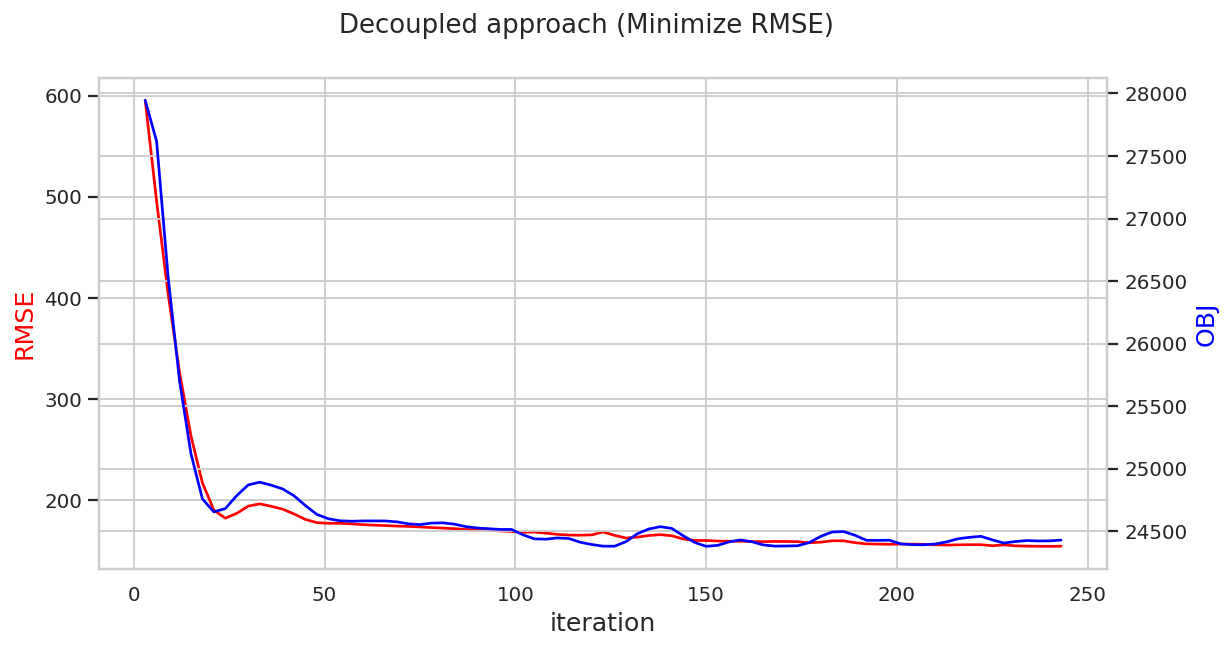

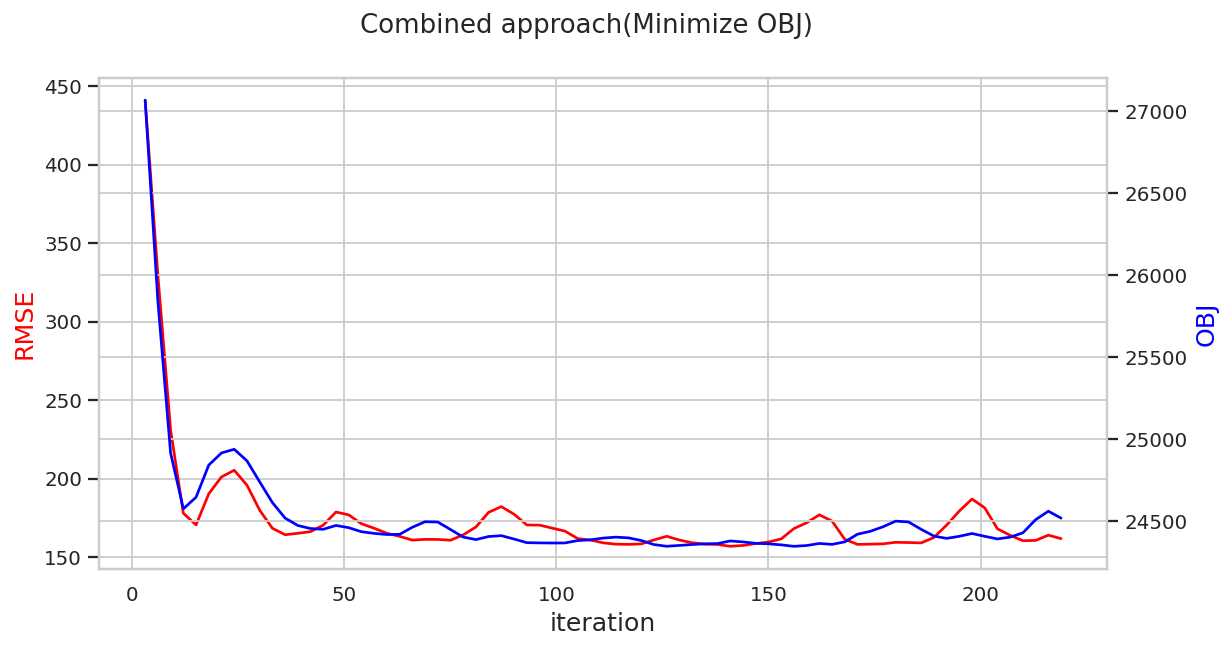

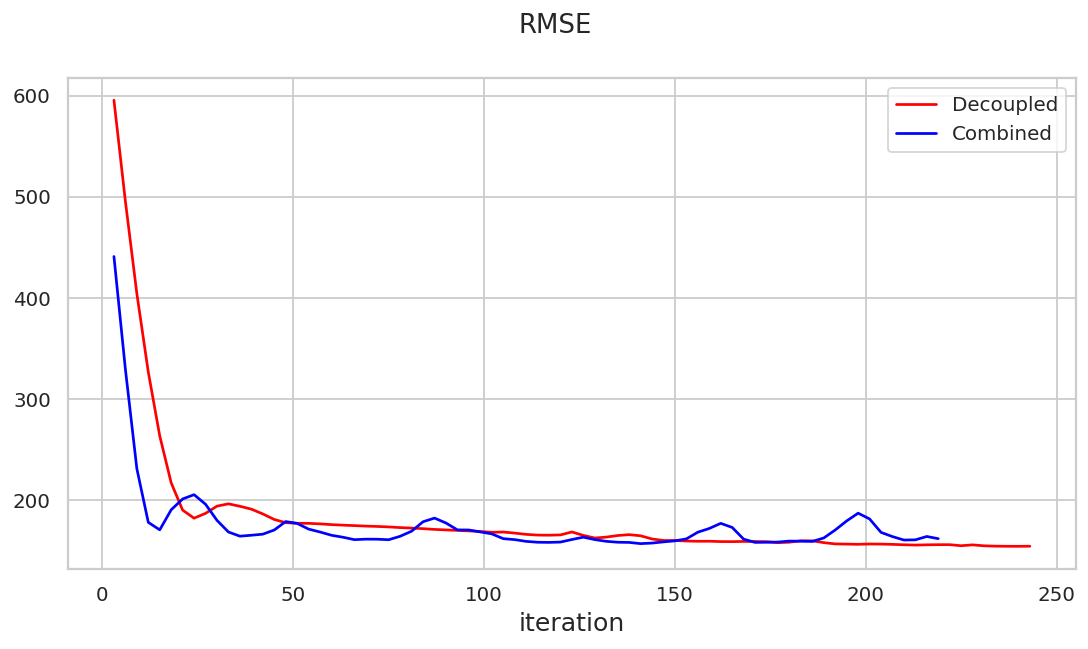

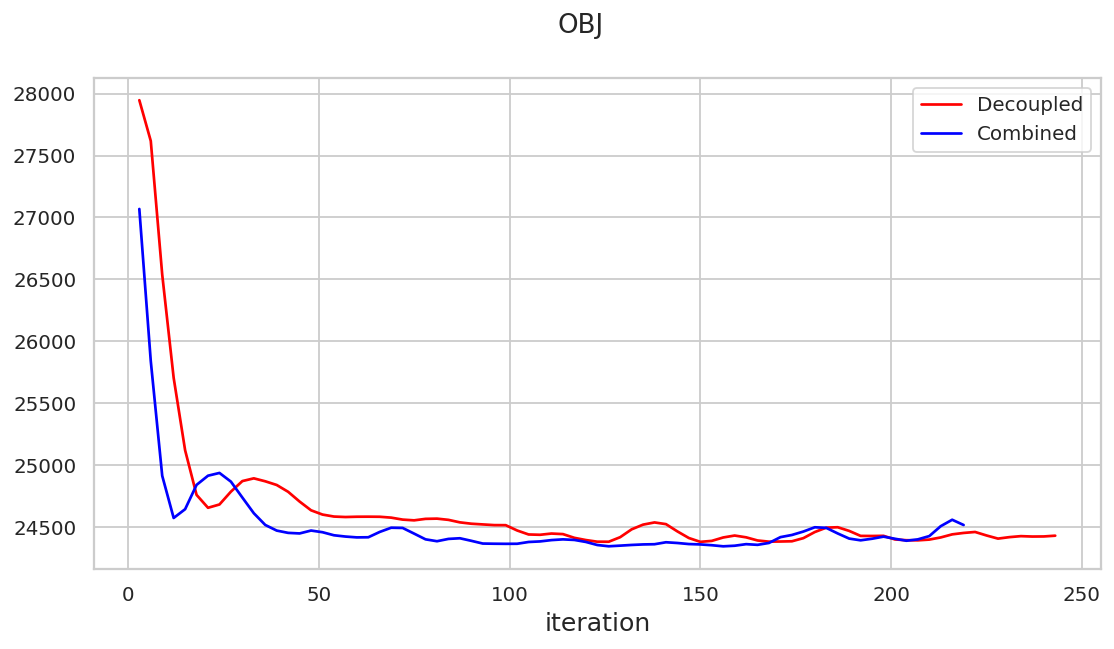

In [18]:
def plot_comparison(title, it_1, val_1, label_1, it_2, val_2, label_2, share_y):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=130)
    fig.suptitle(title)
    ax.plot(it_1, val_1, color="red", label=label_1)
    ax.set_xlabel("iteration",fontsize=14)

    if share_y:
        ax.plot(it_2, val_2,color="blue", label=label_2)
        plt.legend()
        plt.show()
       
    else:
        ax.set_ylabel(label_1,color="red",fontsize=14)
        ax2=ax.twinx()
        ax2.plot(it_2, val_2,color="blue", label=label_2)
        ax2.set_ylabel(label_2, color="blue",fontsize=14)
        

plot_comparison('Decoupled approach (Minimize RMSE)', 
                it_plot_sep, rmse_costs_sep, "RMSE", 
                it_plot_sep, obj_costs_sep, "OBJ", False)

plot_comparison('Combined approach(Minimize OBJ)', 
                it_plot_comb, rmse_costs_comb, "RMSE", 
                it_plot_comb, obj_costs_comb, "OBJ", False)

plot_comparison('RMSE', 
                it_plot_sep, rmse_costs_sep, "Decoupled", 
                it_plot_comb, rmse_costs_comb, "Combined", True)

plot_comparison('OBJ', 
                it_plot_sep, obj_costs_sep, "Decoupled", 
                it_plot_comb, obj_costs_comb, "Combined", True)

***
$\mathbf{\text{Results}}$<br>
***

In [19]:
h_best = SimpleNet(n_feat=dx)
h_best.load_state_dict(torch.load("./models/sep_kkt_{}".format(m_type)))

<All keys matched successfully>

In [20]:
h_best = SimpleNet(n_feat=dx)
h_best.load_state_dict(torch.load("./models/sep_kkt_{}".format(m_type)))

hc_best = SimpleNet(n_feat=dx)
hc_best.load_state_dict(torch.load("./models/com_kkt_{}".format(m_type)))

eval_type = 'disc'
f_day_h = calc_f_per_day(h_best(X_test), y_test, is_discrete, eval_type).data.numpy()
f_day_hc = calc_f_per_day(hc_best(X_test), y_test, is_discrete, eval_type).data.numpy()
f_day = calc_f_per_day(y_test, y_test, is_discrete, eval_type).data.numpy()

print('-------------------- RESULTS --------------------')
print('Decoupled approach: \t\t', f_day_h.mean().round(2))
print('Combined approach: \t\t', f_day_hc.mean().round(2))
print('Ground truth:    \t\t', f_day.mean().round(2))

print('')
print('-------------------- REGRET --------------------')
print('Decoupled average regret: \t', (f_day_h.mean()-f_day.mean()).round(2))
print('Combined average regret: \t', (f_day_hc.mean()-f_day.mean()).round(2))


logging.info('')
logging.info('')
logging.info('--------------------------------------------------')
logging.info('--------------------------------------------------')
logging.info('Date: {}'.format(datetime.date.strftime(datetime.date.today(), '%Y-%m-%d')))
logging.info('')
logging.info('-------------------- Experiment --------------------')
logging.info('Problem type is discrete?: {}'.format(is_discrete))
logging.info('q: {}'.format(q_factor))
logging.info('seed: {}'.format(seed_number))
logging.info('-------------------- RESULTS KKT --------------------')
logging.info('Decoupled approach: \t\t {}'.format(f_day_h.mean().round(2)))
logging.info('Combined approach: \t\t {}'.format(f_day_hc.mean().round(2)))
logging.info('Ground truth:    \t\t {}'.format(f_day.mean().round(2)))

logging.info('')
logging.info('-------------------- REGRET -------------------------')
logging.info('Decoupled average regret: \t {}'.format((f_day_h.mean()-f_day.mean()).round(2)))
logging.info('Combined average regret: \t {}'.format((f_day_hc.mean()-f_day.mean()).round(2)))

-------------------- RESULTS --------------------
Decoupled approach: 		 25062.08
Combined approach: 		 24805.8
Ground truth:    		 19919.88

-------------------- REGRET --------------------
Decoupled average regret: 	 5142.2
Combined average regret: 	 4885.92


(0.0, 0.0002)

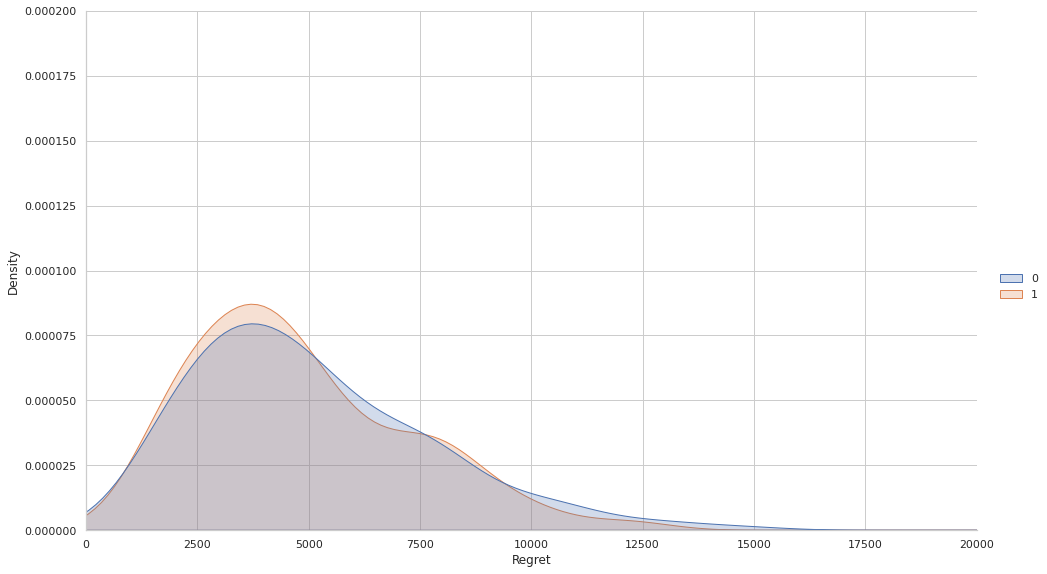

In [21]:
ax = sns.displot([f_day_h - f_day, f_day_hc - f_day], kind="kde", 
                 fill=True, height=8, aspect=10/6, 
                 legend=True,)
ax.set_xlabels('Regret')

plt.xlim([0, 20000])
plt.ylim([0, 0.0002])